In [1]:
#import packages
import os
import random
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img,ImageDataGenerator, array_to_img
from tensorflow.keras.applications import EfficientNetB1

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten,Dense,Conv2D,Dropout,GlobalAveragePooling2D

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
import imutils

In [2]:
#create directory for training data
os.mkdir('C:/Users/sachi/Downloads/Brain_tumor/Crop-Brain-MRI')
os.mkdir('C:/Users/sachi/Downloads/Brain_tumor/Crop-Brain-MRI/glioma_tumor')
os.mkdir('C:/Users/sachi/Downloads/Brain_tumor/Crop-Brain-MRI/meningioma_tumor')
os.mkdir('C:/Users/sachi/Downloads/Brain_tumor/Crop-Brain-MRI/pituitary_tumor')
os.mkdir('C:/Users/sachi/Downloads/Brain_tumor/Crop-Brain-MRI/no_tumor')


#create directory for testing data
os.mkdir('C:/Users/sachi/Downloads/Brain_tumor/Test-Data')
os.mkdir('C:/Users/sachi/Downloads/Brain_tumor/Test-Data/glioma_tumor')
os.mkdir('C:/Users/sachi/Downloads/Brain_tumor/Test-Data/meningioma_tumor')
os.mkdir('C:/Users/sachi/Downloads/Brain_tumor/Test-Data/pituitary_tumor')
os.mkdir('C:/Users/sachi/Downloads/Brain_tumor/Test-Data/no_tumor')

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'C:/Users/sachi/Downloads/Brain_tumor/Crop-Brain-MRI'

In [3]:
train_dir = 'C:/Users/sachi/Downloads/Brain_tumor/Training/'
test_dir = 'C:/Users/sachi/Downloads/Brain_tumor/Testing/'

In [4]:
classes = os.listdir('C:/Users/sachi/Downloads/Brain_tumor/Training')

In [5]:
classes

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

In [6]:
files_path_dict = {}

for c in classes:
  files_path_dict[c] = list(map(lambda x: train_dir + c + '/' + x, os.listdir(train_dir + c)))

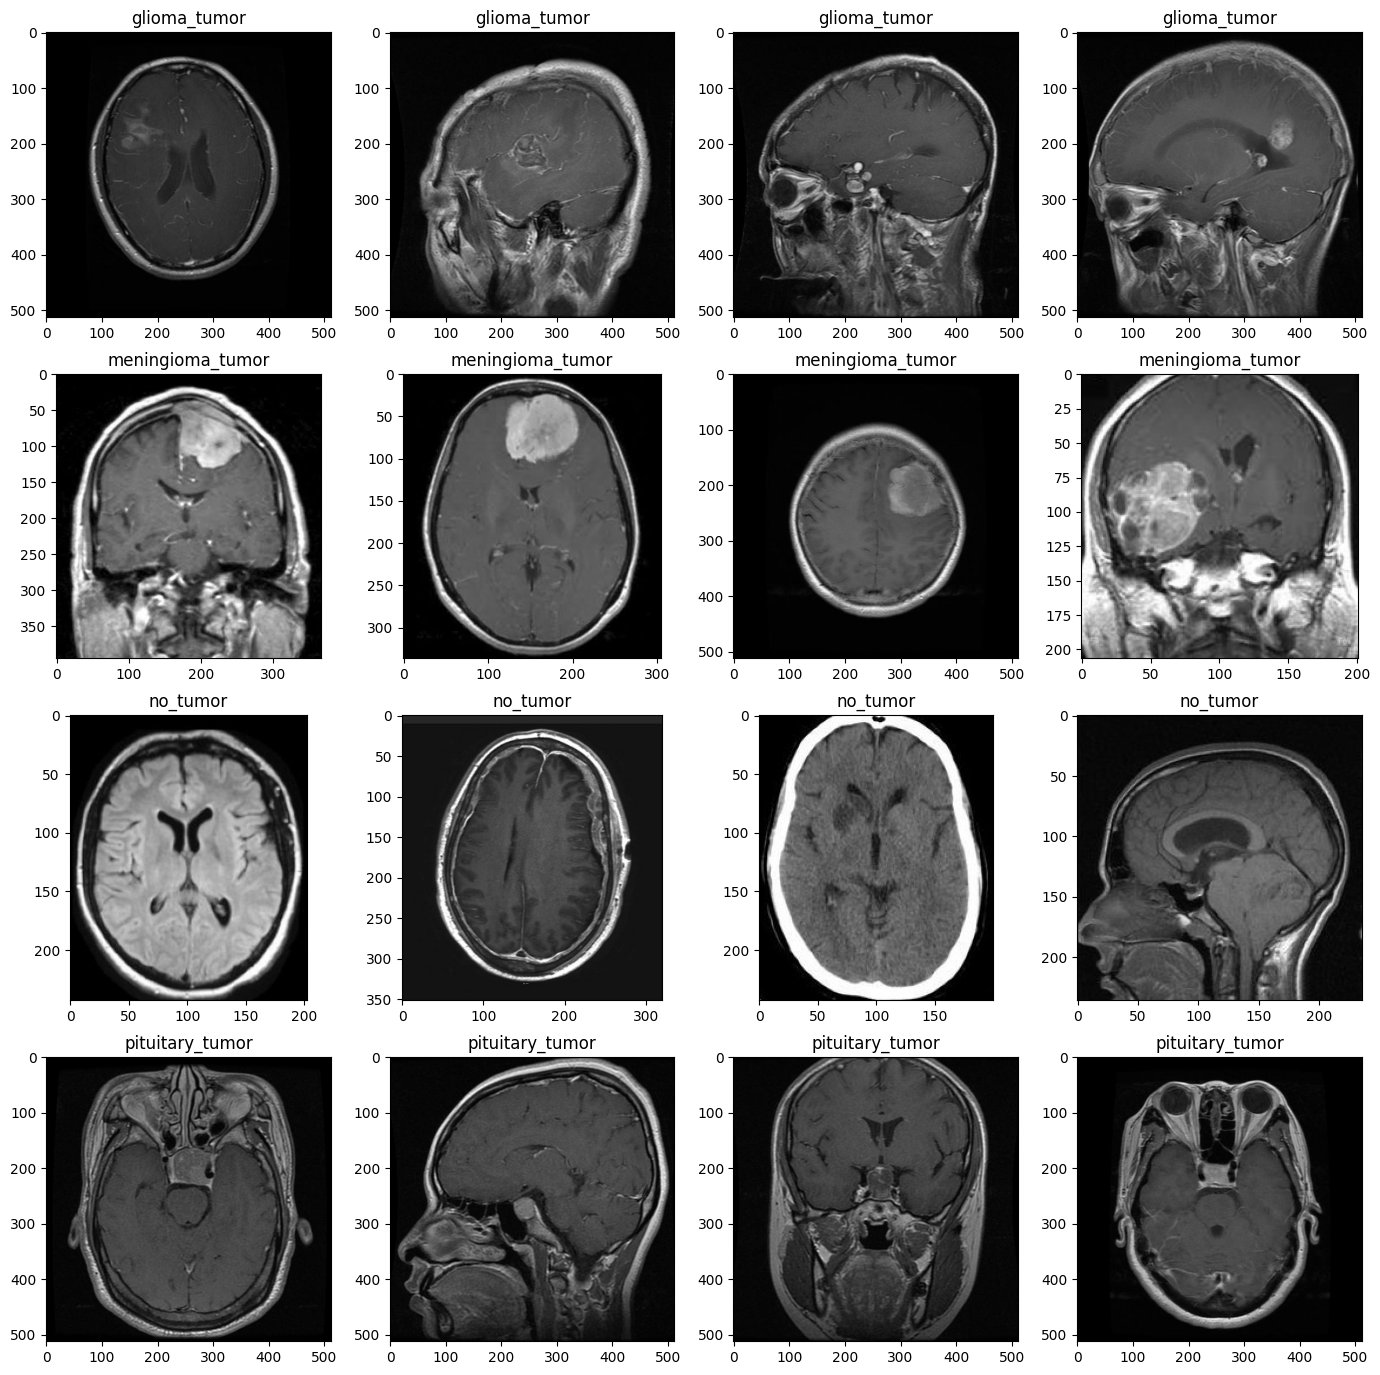

In [7]:
#visualize
plt.figure(figsize = (17,17))
index = 0
for c in classes:
  random.shuffle(files_path_dict[c])
  path_list = files_path_dict[c][:5]

  for i in range(1, 5):
    index += 1
    plt.subplot(4, 4, index)
    plt.imshow(load_img(path_list[i]))
    plt.title(c)

In [10]:
#check the number of images in each class in the training dataset
No_images_per_class = []
Class_name = []

for i in os.listdir('C:/Users/sachi/Downloads/Brain_tumor/Training'):
  train_class = os.listdir(os.path.join('C:/Users/sachi/Downloads/Brain_tumor/Training', i))
  No_images_per_class.append(len(train_class))
  Class_name.append(i)
  print('Number of images in {} = {} \n'.format(i, len(train_class)))

Number of images in glioma_tumor = 826 

Number of images in meningioma_tumor = 822 

Number of images in no_tumor = 395 

Number of images in pituitary_tumor = 827 



In [12]:
import seaborn as sns

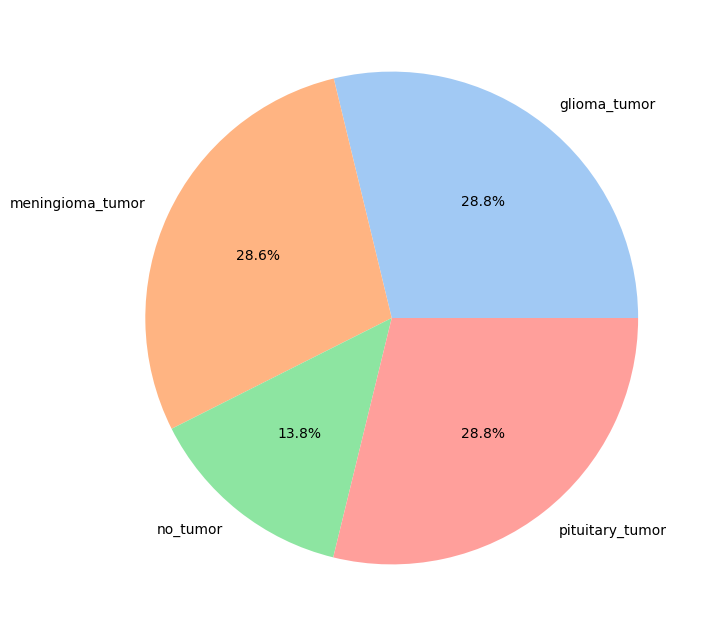

In [13]:
#visualize class distribution in train set
plt.figure(figsize=(8, 8))
colors = sns.color_palette('pastel')
plt.pie(No_images_per_class, 
        labels = Class_name, 
        autopct = '%1.1f%%',
        colors=colors)
plt.show()

In [14]:
def crop_image(image, plot=False):
    
    #convert to grayscale
    img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    #blur
    img_gray = cv2.GaussianBlur(img_gray, (5, 5), 0)
    
    #apply binary threshhold
    img_thresh = cv2.threshold(img_gray, 45, 255, cv2.THRESH_BINARY)[1]

    #apply erosion
    img_thresh = cv2.erode(img_thresh, None, iterations=2)

    #dilate images
    img_thresh = cv2.dilate(img_thresh, None, iterations=2)

    #find shapes or the contour of images
    contours = cv2.findContours(img_thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    #grab contours
    contours = imutils.grab_contours(contours)

    #find biggest contour
    c = max(contours, key=cv2.contourArea)

    #extract contour positions
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    #generate new image
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    #plot
    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)
        plt.tick_params(axis='both', which='both',top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Cropped Image')
        plt.show()
    
    return new_image

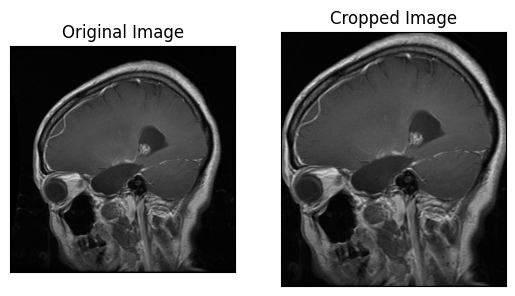

In [16]:
example_image = cv2.imread('C:/Users/sachi/Downloads/Brain_tumor/Training/glioma_tumor/gg (101).jpg')
cropped_image = crop_image(example_image, plot=True)

In [17]:
#crop training images and save it to the directory we previously created
glioma = train_dir + 'glioma_tumor'
meningioma = train_dir + 'meningioma_tumor'
pituitary = train_dir + 'pituitary_tumor'
no_tumor = train_dir + 'no_tumor'

j = 0
for i in tqdm(os.listdir(glioma)):
  path = os.path.join(glioma, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)

  if img is not None:
    img = cv2.resize(img, (240, 240))
    save_path = 'C:/Users/sachi/Downloads/Brain_tumor/Crop-Brain-MRI/glioma_tumor/' + str(j) + '.jpg'
    cv2.imwrite(save_path, img)
    j = j + 1

j = 0
for i in tqdm(os.listdir(meningioma)):
  path = os.path.join(meningioma, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)

  if img is not None:
    img = cv2.resize(img, (240, 240))
    save_path = 'C:/Users/sachi/Downloads/Brain_tumor/Crop-Brain-MRI/meningioma_tumor/' + str(j) + '.jpg'
    cv2.imwrite(save_path, img)
    j = j + 1  

j = 0
for i in tqdm(os.listdir(pituitary)):
  path = os.path.join(pituitary, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)

  if img is not None:
    img = cv2.resize(img, (240, 240))
    save_path = 'C:/Users/sachi/Downloads/Brain_tumor/Crop-Brain-MRI/pituitary_tumor/' + str(j) + '.jpg'
    cv2.imwrite(save_path, img)
    j = j + 1  

j = 0
for i in tqdm(os.listdir(no_tumor)):
  path = os.path.join(no_tumor, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)

  if img is not None:
    img = cv2.resize(img, (240, 240))
    save_path = 'C:/Users/sachi/Downloads/Brain_tumor/Crop-Brain-MRI/no_tumor/' + str(j) + '.jpg'
    cv2.imwrite(save_path, img)
    j = j + 1  

100%|████████████████████████████████████████████████████████████████████████████████| 395/395 [00:05<00:00, 71.43it/s]


In [18]:
#crop testing images and save it to the directory we previously created
test_glioma = test_dir + 'glioma_tumor'
test_meningioma = test_dir + 'meningioma_tumor'
test_pituitary = test_dir + 'pituitary_tumor'
test_no_tumor = test_dir + 'no_tumor'

j = 0
for i in tqdm(os.listdir(test_glioma)):
  path = os.path.join(test_glioma, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)

  if img is not None:
    img = cv2.resize(img, (240, 240))
    save_path = 'C:/Users/sachi/Downloads/Brain_tumor/Test-Data/glioma_tumor/' + str(j) + '.jpg'
    cv2.imwrite(save_path, img)
    j = j + 1

j = 0
for i in tqdm(os.listdir(test_meningioma)):
  path = os.path.join(test_meningioma, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)

  if img is not None:
    img = cv2.resize(img, (240, 240))
    save_path = 'C:/Users/sachi/Downloads/Brain_tumor/Test-Data/meningioma_tumor/' + str(j) + '.jpg'
    cv2.imwrite(save_path, img)
    j = j + 1  

j = 0
for i in tqdm(os.listdir(test_pituitary)):
  path = os.path.join(test_pituitary, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)

  if img is not None:
    img = cv2.resize(img, (240, 240))
    save_path = 'C:/Users/sachi/Downloads/Brain_tumor/Test-Data/pituitary_tumor/' + str(j) + '.jpg'
    cv2.imwrite(save_path, img)
    j = j + 1  

j = 0
for i in tqdm(os.listdir(test_no_tumor)):
  path = os.path.join(test_no_tumor, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)

  if img is not None:
    img = cv2.resize(img, (240, 240))
    save_path = 'C:/Users/sachi/Downloads/Brain_tumor/Test-Data/no_tumor/' + str(j) + '.jpg'
    cv2.imwrite(save_path, img)
    j = j + 1  

100%|████████████████████████████████████████████████████████████████████████████████| 105/105 [00:01<00:00, 64.19it/s]


In [19]:
#use Image Data Generator to perform this task
#train set
datagen = ImageDataGenerator(rotation_range=10,
                             height_shift_range=0.2,
                             horizontal_flip=True,
                             validation_split=0.2)

train_data = datagen.flow_from_directory('C:/Users/sachi/Downloads/Brain_tumor/Crop-Brain-MRI/',
                                         target_size=(240, 240),
                                         batch_size=32,
                                         class_mode='categorical',
                                         subset='training')

valid_data = datagen.flow_from_directory('C:/Users/sachi/Downloads/Brain_tumor/Crop-Brain-MRI/',
                                         target_size=(240, 240),
                                         batch_size=32,
                                         class_mode='categorical',
                                         subset='validation')

#test set
test_datagen = ImageDataGenerator()

test_data = datagen.flow_from_directory('C:/Users/sachi/Downloads/Brain_tumor/Test-Data/',
                                         target_size=(240, 240),
                                        class_mode='categorical',
                                        shuffle=False)
                                        

Found 2297 images belonging to 4 classes.
Found 573 images belonging to 4 classes.
Found 394 images belonging to 4 classes.


In [20]:
#view the class dictionary
print(train_data.class_indices)
print(test_data.class_indices)

{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}
{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}


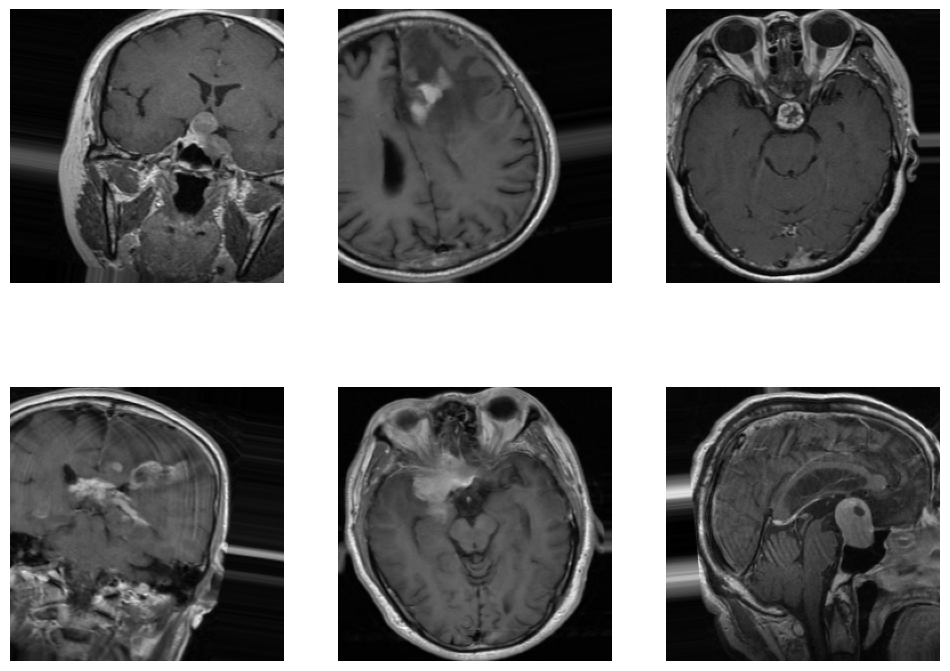

In [21]:
#view the augmented data
sample_x, sample_y = next(train_data)
plt.figure(figsize=(12, 9))
for i in range(6):
  plt.subplot(2, 3, i+1)
  sample = array_to_img(sample_x[i])
  plt.axis('off')
  plt.grid(False)
  plt.imshow(sample)
plt.show()

## Convolutional Neural Network Model (CNN) and Transfer Learning with EfficientNet

In [57]:
#build the model
effnet = EfficientNetB1(weights='imagenet', 
                        include_top=False, 
                        input_shape=(240, 240, 3))
for layer in effnet.layers:
    layer.trainable = False

model = effnet.output
model = GlobalAveragePooling2D()(model)
model = Dropout(0.5)(model)
model = Dense(4, activation='softmax')(model)
model = Model(inputs=effnet.input, 
              outputs=model)

#get summary()
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 240, 240, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_6 (Rescaling)        (None, 240, 240, 3)  0           ['input_4[0][0]']                
                                                                                                  
 normalization_3 (Normalization  (None, 240, 240, 3)  7          ['rescaling_6[0][0]']            
 )                                                                                                
                                                                                            

                                                                                                  
 block2a_expand_conv (Conv2D)   (None, 120, 120, 96  1536        ['block1b_add[0][0]']            
                                )                                                                 
                                                                                                  
 block2a_expand_bn (BatchNormal  (None, 120, 120, 96  384        ['block2a_expand_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 block2a_expand_activation (Act  (None, 120, 120, 96  0          ['block2a_expand_bn[0][0]']      
 ivation)                       )                                                                 
                                                                                                  
 block2a_d

 block2c_expand_activation (Act  (None, 60, 60, 144)  0          ['block2c_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block2c_dwconv (DepthwiseConv2  (None, 60, 60, 144)  1296       ['block2c_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block2c_bn (BatchNormalization  (None, 60, 60, 144)  576        ['block2c_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block2c_activation (Activation  (None, 60, 60, 144)  0          ['block2c_bn[0][0]']             
 )        

 )                                                                                                
                                                                                                  
 block3b_activation (Activation  (None, 30, 30, 240)  0          ['block3b_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block3b_se_squeeze (GlobalAver  (None, 240)         0           ['block3b_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block3b_se_reshape (Reshape)   (None, 1, 1, 240)    0           ['block3b_se_squeeze[0][0]']     
                                                                                                  
 block3b_s

 block4a_activation (Activation  (None, 15, 15, 240)  0          ['block4a_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block4a_se_squeeze (GlobalAver  (None, 240)         0           ['block4a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block4a_se_reshape (Reshape)   (None, 1, 1, 240)    0           ['block4a_se_squeeze[0][0]']     
                                                                                                  
 block4a_se_reduce (Conv2D)     (None, 1, 1, 10)     2410        ['block4a_se_reshape[0][0]']     
                                                                                                  
 block4a_s

 block4c_se_expand (Conv2D)     (None, 1, 1, 480)    10080       ['block4c_se_reduce[0][0]']      
                                                                                                  
 block4c_se_excite (Multiply)   (None, 15, 15, 480)  0           ['block4c_activation[0][0]',     
                                                                  'block4c_se_expand[0][0]']      
                                                                                                  
 block4c_project_conv (Conv2D)  (None, 15, 15, 80)   38400       ['block4c_se_excite[0][0]']      
                                                                                                  
 block4c_project_bn (BatchNorma  (None, 15, 15, 80)  320         ['block4c_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block4c_d

 block5a_project_conv (Conv2D)  (None, 15, 15, 112)  53760       ['block5a_se_excite[0][0]']      
                                                                                                  
 block5a_project_bn (BatchNorma  (None, 15, 15, 112)  448        ['block5a_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block5b_expand_conv (Conv2D)   (None, 15, 15, 672)  75264       ['block5a_project_bn[0][0]']     
                                                                                                  
 block5b_expand_bn (BatchNormal  (None, 15, 15, 672)  2688       ['block5b_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block5b_e

 block5d_expand_conv (Conv2D)   (None, 15, 15, 672)  75264       ['block5c_add[0][0]']            
                                                                                                  
 block5d_expand_bn (BatchNormal  (None, 15, 15, 672)  2688       ['block5d_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block5d_expand_activation (Act  (None, 15, 15, 672)  0          ['block5d_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block5d_dwconv (DepthwiseConv2  (None, 15, 15, 672)  16800      ['block5d_expand_activation[0][0]
 D)                                                              ']                               
          

                                                                                                  
 block6b_dwconv (DepthwiseConv2  (None, 8, 8, 1152)  28800       ['block6b_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block6b_bn (BatchNormalization  (None, 8, 8, 1152)  4608        ['block6b_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block6b_activation (Activation  (None, 8, 8, 1152)  0           ['block6b_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block6b_s

 )                                                                                                
                                                                                                  
 block6d_activation (Activation  (None, 8, 8, 1152)  0           ['block6d_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block6d_se_squeeze (GlobalAver  (None, 1152)        0           ['block6d_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block6d_se_reshape (Reshape)   (None, 1, 1, 1152)   0           ['block6d_se_squeeze[0][0]']     
                                                                                                  
 block6d_s

 block7a_se_squeeze (GlobalAver  (None, 1152)        0           ['block7a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block7a_se_reshape (Reshape)   (None, 1, 1, 1152)   0           ['block7a_se_squeeze[0][0]']     
                                                                                                  
 block7a_se_reduce (Conv2D)     (None, 1, 1, 48)     55344       ['block7a_se_reshape[0][0]']     
                                                                                                  
 block7a_se_expand (Conv2D)     (None, 1, 1, 1152)   56448       ['block7a_se_reduce[0][0]']      
                                                                                                  
 block7a_se_excite (Multiply)   (None, 8, 8, 1152)   0           ['block7a_activation[0][0]',     
          

In [64]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
import json
#compile model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

import numpy as np

# Create a custom ModelCheckpoint callback
class CustomModelCheckpoint(ModelCheckpoint):
    def __init__(self, filepath, monitor, verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1):
        super().__init__(filepath, monitor, verbose, save_best_only, save_weights_only, mode, period)

    def on_epoch_end(self, epoch, logs=None):
        super().on_epoch_end(epoch, logs)
        
# Create a custom ModelCheckpoint callback
checkpoint = CustomModelCheckpoint(
    filepath="model.h5",
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False,
    mode='max',
    verbose=1
)

#early stopping
earlystop = EarlyStopping(monitor='val_accuracy',
                          patience=5,
                          mode='auto',
                          verbose=1)

#reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', 
                              factor = 0.3, 
                              patience = 2, 
                              min_delta = 0.001,
                              mode='auto',
                              verbose=1)

In [69]:
#train the model
history = model.fit(train_data,
                    batch_size= 32,
                    epochs = 30,
                    validation_data=valid_data,
                    verbose=1,
                    callbacks=[earlystop, reduce_lr]
                   )

Epoch 1/30
72/72 [==============================] - 32s 447ms/step - loss: 0.7270 - accuracy: 0.7183 - val_loss: 0.7598 - val_accuracy: 0.7068 - lr: 8.1000e-07
Epoch 2/30
17/72 [======>.......................] - ETA: 19s - loss: 0.6909 - accuracy: 0.7426

KeyboardInterrupt: 

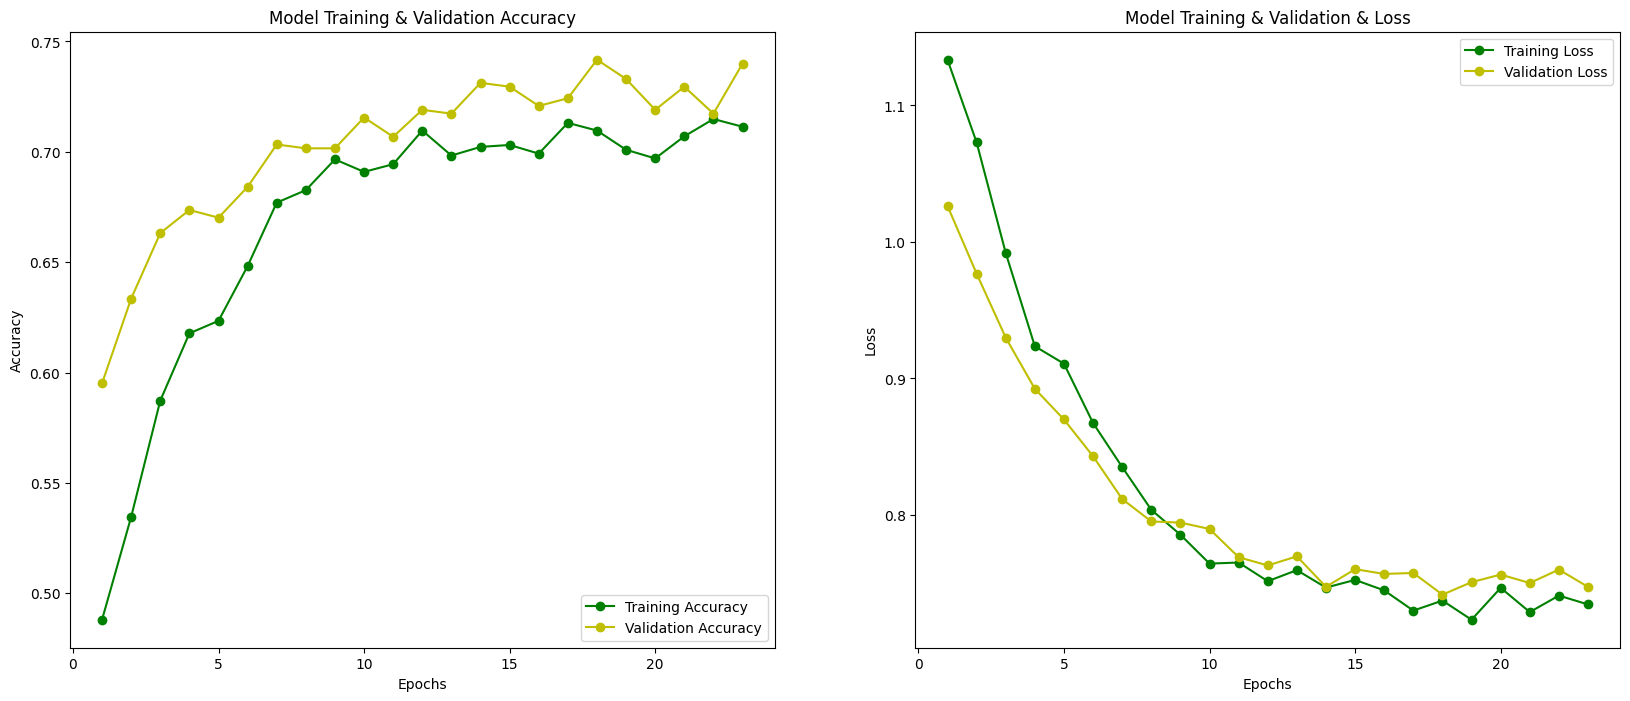

In [66]:
fig , ax = plt.subplots(1,2)
fig.set_size_inches(20, 8)

train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = range(1, len(train_acc) + 1)

ax[0].plot(epochs , train_acc , 'g-o' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'y-o' , label = 'Validation Accuracy')
ax[0].set_title('Model Training & Validation Accuracy')
ax[0].legend(loc = 'lower right')
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'y-o' , label = 'Validation Loss')
ax[1].set_title('Model Training & Validation & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")

plt.show()

In [67]:
print('Train accuracy & loss:', model.evaluate(train_data))
print('\n')
print('Test accuracy & loss:', model.evaluate(test_data))

72/72 [==============================] - 31s 424ms/step - loss: 0.6332 - accuracy: 0.7819
Train accuracy & loss: [0.6332186460494995, 0.7818894386291504]


13/13 [==============================] - 5s 365ms/step - loss: 1.0385 - accuracy: 0.5711
Test accuracy & loss: [1.0384647846221924, 0.5710659623146057]


In [68]:
#define labels for testing
y_test = test_data.classes

#make prediction
yhat_test = np.argmax(model.predict(test_data), axis=1)

13/13 [==============================] - 10s 531ms/step


In [42]:
import itertools
#from tensorflow.keras.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix

[[31 41 21  7]
 [18 56 24 17]
 [ 5  9 86  5]
 [ 3  9  1 61]]


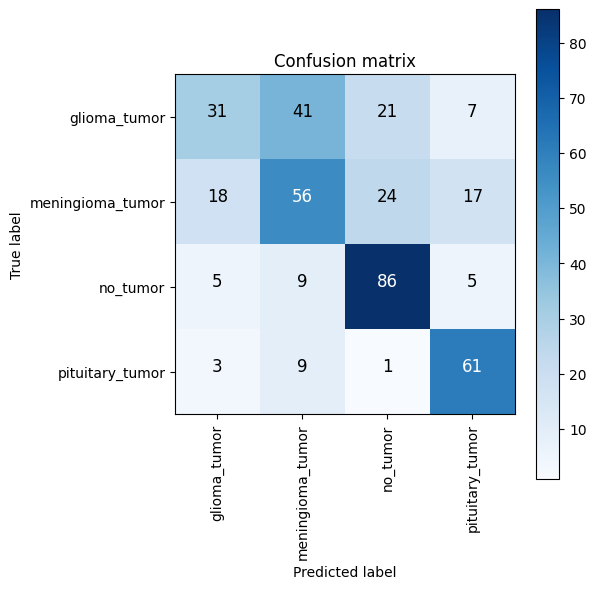

In [44]:
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion matrix',
                          cmap = plt.cm.Blues):
    
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    plt.grid(False)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 fontsize = 12,
                 horizontalalignment = "center",
                 color = "white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
      
#get confusion matrix
cm = confusion_matrix(y_test, yhat_test)
print(cm)

#plot
plot_confusion_matrix(cm, classes, normalize=False)